# EnKF Experiments - GCS

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder, Inflation, ExitRandomisation, GateEstimator
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

## Data paths

In [6]:
data_dir = '../results/data/exp1/'
model_dir = '../results/models/exp1/'
fig_dir = '../results/figures/exp1/'

## Experiment 1 - Setting Up EnKF

### Base model inclusion in error calculations

In [7]:
p = 5
e = 100
a = 100

In [8]:
Modeller.run_experiment_1(pop_size=p, ensemble_size=e, assimilation_period=a,
                          standardise_state=True,
                          inclusion=AgentIncluder.MODE_EN,
                          gate_estimator=GateEstimator.ANGLE,
                          exit_randomisation=ExitRandomisation.ALL_RANDOM,
                          n_adjacent=1)

/home/keiran/Documents/dev/dust/Projects/ABM_DA/experiments/enkf_experiments/results_3/noteooks/../../../../stationsim/ensemble_kalman_filter.py:208: RuntimeWarning: EnKF received unexpected attribute (vanilla_ensemble_size).
  warns.warn(w, RuntimeWarning)
/home/keiran/Documents/dev/dust/Projects/ABM_DA/experiments/enkf_experiments/results_3/noteooks/../../../../stationsim/ensemble_kalman_filter.py:208: RuntimeWarning: EnKF received unexpected attribute (inflation_rate).
  warns.warn(w, RuntimeWarning)


Running Ensemble Kalman Filter...
max_iterations:	5000
ensemble_size:	100
assimilation_period:	100
pop_size:	5
filter_type:	EnsembleKalmanFilterType.DUAL_EXIT
inclusion_type:	AgentIncluder.MODE_EN
ensemble_errors:	False


In [9]:
Processor.process_experiment_1(pop_size=p)

#### Read data

In [10]:
results = pd.read_csv(data_dir + f'p{p}/metrics.csv')
results.head()

,time,forecast,obs,exit_accuracy,analysis,baseline
0,100,44.955585,0.871939,0.0,0.885834,0.885834
1,200,49.801748,0.733577,0.4,0.721112,0.721112
2,300,49.411908,1.351472,0.6,1.367111,1.367111
3,400,56.399352,1.183969,0.4,1.211127,1.211127
4,500,53.195223,0.847037,0.6,0.992681,0.992681


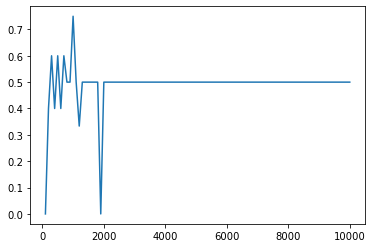

In [11]:
plt.figure()
plt.plot(results['time'], results['exit_accuracy'])
plt.show()

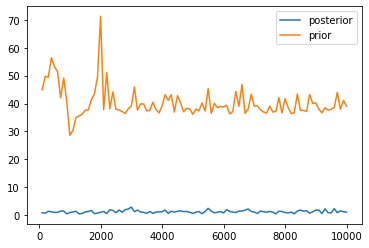

In [12]:
plt.figure()
plt.plot(results['time'], results['analysis'], label='posterior')
plt.plot(results['time'], results['forecast'], label='prior')
plt.legend()
plt.show()

In [13]:
with open(f'../results/models/exp1/p{p}/model.pkl', 'rb') as f:
    enkf = pickle.load(f)

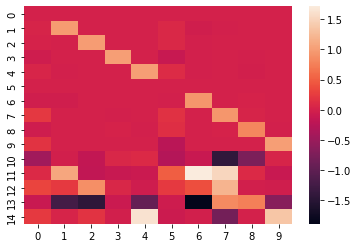

In [14]:
sns.heatmap(enkf.gain_matrix)
plt.show()

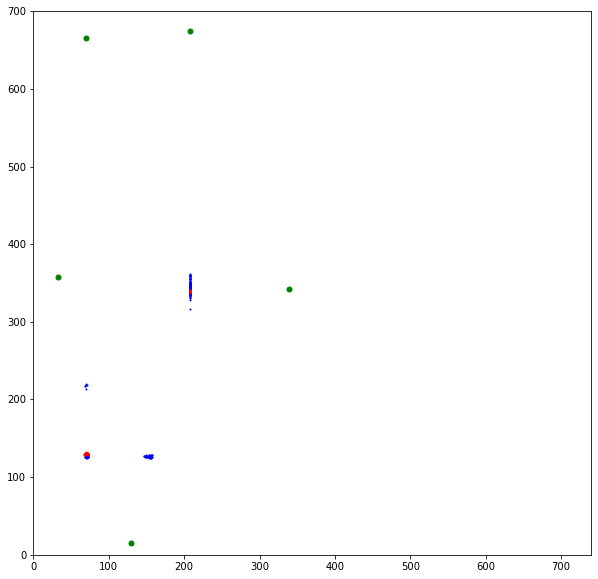

In [15]:
x = -1

plt.figure(figsize=(10, 10))

truth = enkf.results[x]['ground_truth']
truth_x = truth[::2]
truth_y = truth[1::2]
plt.scatter(truth_x, truth_y, color='green', s=25)



for i in range(e):
    prior_label = f'prior_{i}'
    posterior_label = f'posterior_{i}'
    
    prior = enkf.results[x][prior_label]
    posterior = enkf.results[x][posterior_label]
    
    
    prior_x = prior[:2]
    prior_y = prior[2:4]
    posterior_x = posterior[:2]
    posterior_y = posterior[2:4]
    
    plt.scatter(prior_x, prior_y, color='blue', s=1)
    plt.scatter(posterior_x, posterior_y, color='red', s=1)

plt.xlim((0, 740))
plt.ylim((0, 700))
plt.show()

In [16]:
output = list()
for r in enkf.results:
    d = dict()
    # get time
    d['time'] = r['time']
    
    for i in range(enkf.population_size):        
        # get truth
        truth = r['ground_truth']
        d[f'truth_x_{i}'] = truth[2*i]
        d[f'truth_y_{i}'] = truth[(2*i)+1]

        # get prior
        prior = r['prior']
        d[f'prior_x_{i}'] = prior[i]
        d[f'prior_y_{i}'] = prior[i + enkf.population_size]

        # get posterior
        posterior = r['posterior']
        d[f'posterior_x_{i}'] = posterior[i]
        d[f'posterior_y_{i}'] = posterior[i + enkf.population_size]

        # get obs
        obs = r['observation']
        d[f'obs_x_{i}'] = obs[2*i]
        d[f'obs_y_{i}'] = obs[(2*i)+1]

        # get origin and destination
        origin = r['origin']
        d[f'origin_x_{i}'] = origin[2*i]
        d[f'origin_y_{i}'] = origin[(2*i)+1]
        destination = r['destination']
        d[f'dest_x_{i}'] = destination[2*i]
        d[f'dest_y_{i}'] = destination[(2*i)+1]
    
    output.append(d)
    
output = pd.DataFrame(output)


In [17]:
output.head()

,time,truth_x_0,truth_y_0,prior_x_0,prior_y_0,posterior_x_0,posterior_y_0,obs_x_0,obs_y_0,origin_x_0,...,prior_x_4,prior_y_4,posterior_x_4,posterior_y_4,obs_x_4,obs_y_4,origin_x_4,origin_y_4,dest_x_4,dest_y_4
0,100,685.753999,238.703256,702.420139,258.354880,686.198683,238.216253,686.068730,238.040064,732.65,...,716.399178,632.118653,699.669491,635.983816,699.433469,636.058597,732.65,650.614511,7.35,346.496057
1,200,638.857998,281.465686,665.825576,208.376890,638.931882,281.132015,638.864322,281.128292,732.65,...,663.491562,589.657055,611.314069,599.972787,611.237847,599.878894,732.65,650.614511,7.35,346.496057
2,300,591.961997,324.228116,659.695154,300.747385,594.579844,323.924263,594.337782,324.055746,732.65,...,627.076864,570.775653,523.422538,562.970253,523.434909,563.013590,732.65,650.614511,7.35,346.496057
3,400,545.065996,366.990545,626.572392,357.597065,545.729773,365.858666,545.661132,366.075931,732.65,...,570.162140,536.785225,434.220290,524.213783,434.118569,524.161580,732.65,650.614511,7.35,346.496057
4,500,498.169994,409.752975,550.406638,416.409854,498.330471,410.468852,497.984091,410.468862,732.65,...,482.593773,474.911892,348.063759,489.202002,347.810914,488.845311,732.65,650.614511,7.35,346.496057


In [18]:
def plot_path(output, aid, show_obs=True, show_od=True):
    print(f'Agent {aid}')
    plt.figure(figsize=(10, 10))
    plt.plot(output[f'truth_x_{aid}'], output[f'truth_y_{aid}'], label=f'truth_{aid}', color='green')
    plt.plot(output[f'prior_x_{aid}'], output[f'prior_y_{aid}'], label=f'prior_{aid}', color='blue')
    plt.plot(output[f'posterior_x_{aid}'], output[f'posterior_y_{aid}'], label=f'posterior_{aid}', color='orange')

    if show_obs:
        plt.scatter(output[f'obs_x_{aid}'], output[f'obs_y_{aid}'], label=f'obs_{aid}', s=1, color='green')
        
    if show_od:
        plt.scatter(output[f'origin_x_{aid}'], output[f'origin_y_{aid}'], label=f'origin_{aid}', s=25, color='blue')
        plt.scatter(output[f'dest_x_{aid}'], output[f'dest_y_{aid}'], label=f'destination_{aid}', s=25, color='orange')

    plt.xlim((0, 740))
    plt.ylim((0, 700))
    plt.legend()
    plt.show()

Agent 0


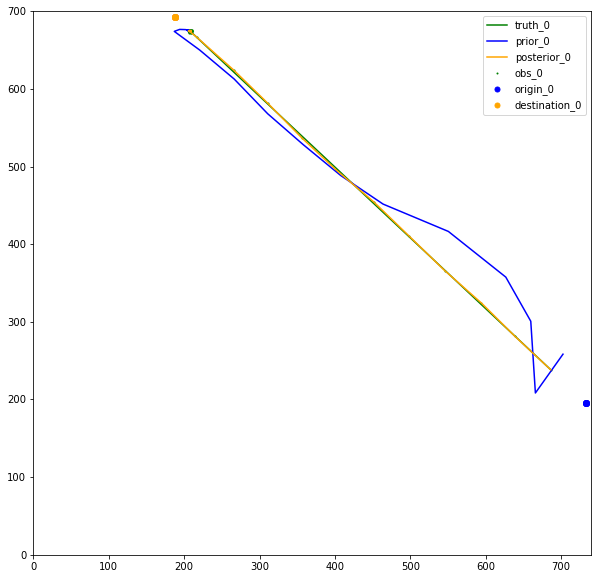

Agent 1


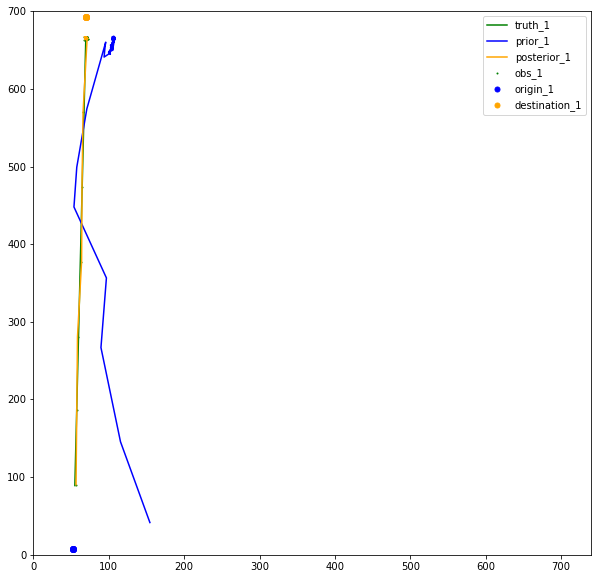

Agent 2


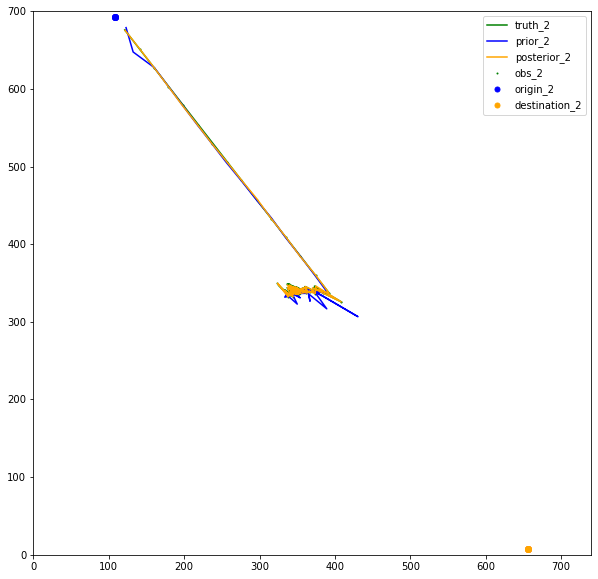

Agent 3


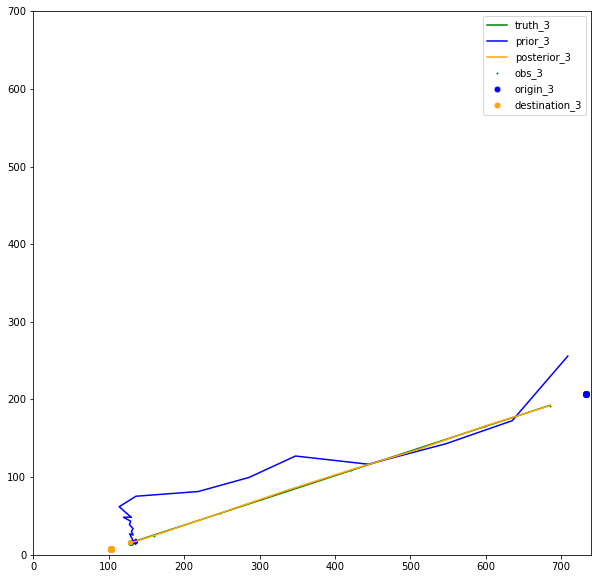

Agent 4


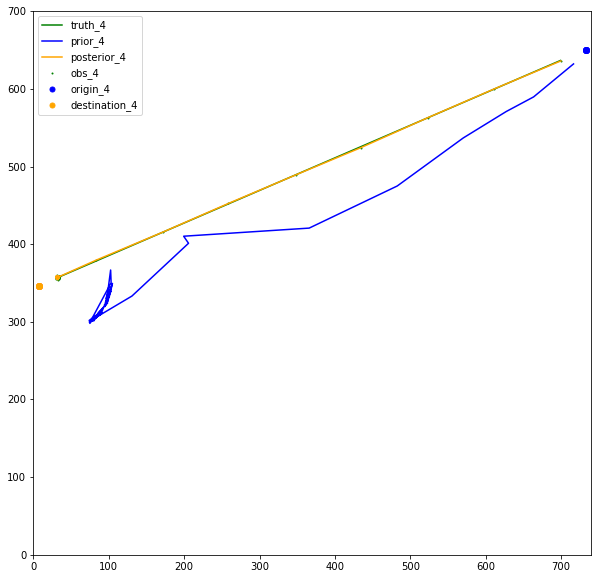

In [19]:
for i in range(enkf.population_size):
    plot_path(output, i)

In [24]:
def present_gate_estimates(agent_number, show_initial=True):
    idx = (2 * enkf.population_size) + agent_number
    true_gate = enkf.base_model.agents[agent_number].gate_out
    print(f'Base model gate value: {true_gate}')

    if hasattr(enkf, 'gate_angles'):
        gate_edges = enkf.gate_angles[true_gate]
        print(f'Gate edge angles: {gate_edges}')

        gate_vals = enkf.state_ensemble[idx]
    print(f'Gate value across ensemble: {gate_vals}')
    
    plt.hist(gate_vals, label='final', alpha=0.5, color='orange')
    if show_initial:
        plt.hist(enkf.initial_gates[agent_number], label='initial', alpha=0.5, color='blue')
    
    plt.legend()
    plt.show()

0
Base model gate value: 1
Gate edge angles: (1.9010936816241504, 2.3839651267857658)
Gate value across ensemble: [-1.58598798e+00 -1.36966416e-01  7.78558568e-01  3.27286397e-01
  3.90185498e-01 -3.69317867e-01  1.91379570e-01  1.38302687e+00
  4.15241294e-01  2.37221752e-01  5.34822471e-01  1.96874387e+00
  6.49705208e-02 -4.47430541e-01  4.51247270e-01  1.77808281e+00
  5.68639882e-01 -5.56886848e-02 -1.07070012e+00  7.40185366e-03
 -1.95551296e-01  3.35470360e-01  9.03026431e-01  6.26632360e-01
  3.68470762e-01  6.48061757e-01 -2.91597212e-01  3.37912947e-01
  2.01790533e+00  3.37997501e-01  1.21281712e+00  9.43103781e-01
  5.54284071e-02  1.03923526e+00  4.09703051e-02  5.77609230e-01
  7.11824741e-02 -3.11325341e-01  1.27842801e-01  3.14552287e-01
  1.53404653e-01 -6.40294843e-01  7.23522817e-02  6.75313641e-01
  3.47084718e-01  1.41798549e-01  2.96906930e-01  1.82409146e+00
  9.87574060e-01  5.72059747e-01 -1.21268917e-01  1.11778050e+00
  1.00399237e+00  1.52513679e-01  6.51231

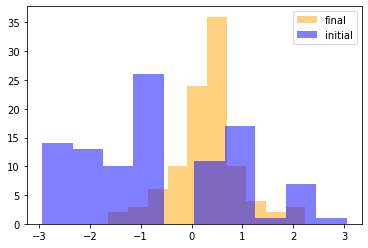

1
Base model gate value: 1
Gate edge angles: (1.9010936816241504, 2.3839651267857658)
Gate value across ensemble: [ 0.31931105  0.11234536  0.31180098 -0.53857638 -0.27401889 -0.68985671
 -0.10615813 -0.54245216 -0.48019685 -0.11110978 -0.12557834 -1.0778872
 -0.12629133 -0.18566396  0.4397143   0.58615245 -0.19913994  0.31498588
 -0.04791136 -0.05755329 -0.23222421 -0.24227386 -0.56446264  0.18852509
 -0.37222441 -1.08535075  0.34967818 -0.61872378 -0.63304348 -0.49841637
 -0.80379767 -0.45997552  0.82936937 -0.66226055  0.44306707  0.51330914
 -0.34182528 -0.01221211 -0.06248815  0.48921917 -0.57945821 -0.23435171
 -0.65520249 -0.20663778 -0.15437014 -0.19440913 -0.14778583 -0.2207531
  0.18667216 -1.52021483 -0.01122932 -0.17085357 -0.19238898 -0.27837136
 -0.61061533  0.21952014 -0.26542517 -0.51010009 -0.77641342  0.30308841
 -0.51687955 -0.22117637 -0.21698881 -0.13324885 -0.1420376  -0.0353907
 -0.77025922 -0.08483714 -0.20783429 -0.9881049  -0.11736017 -0.84271317
  0.51247716 

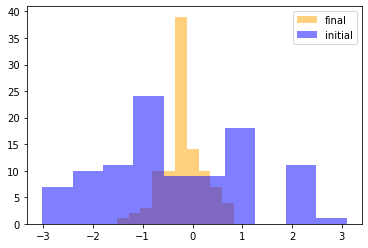

2
Base model gate value: 7
Gate edge angles: (-0.7576275268040272, -1.0845536937073916)
Gate value across ensemble: [-0.76912808 -0.8836783  -0.78590898 -0.97036468 -0.92858792 -0.74046655
 -0.87395795 -0.81811305 -0.92490244 -0.86222648 -0.85272129 -0.86749606
 -0.78233823 -0.8820061  -0.81718508 -0.93511086 -0.79544577 -0.76440564
 -0.83090423 -0.79345051 -0.80705433 -0.85016196 -0.90780906 -0.80917755
 -0.82230894 -0.85516348 -0.86216218 -0.94568677 -0.80184127 -0.84187628
 -0.80723007 -0.83116639 -1.09603379 -0.8115695  -0.91299156 -0.9246012
 -0.81237579 -0.82985949 -0.84811404 -0.88694134 -0.85278398 -0.88902122
 -0.78257949 -0.93155445 -0.7959566  -0.8136729  -0.92056475 -0.87188814
 -0.91916814 -0.86922096 -0.85189511 -0.77152883 -0.78926653 -0.88968791
 -0.84404549 -0.84220668 -0.87591784 -0.69202489 -0.80341572 -0.97700825
 -0.81686478 -0.83244154 -0.81975967 -0.77218184 -1.01344516 -0.8700042
 -0.87944406 -0.86189108 -0.87595894 -0.89698115 -0.84054117 -0.89359185
 -0.798503

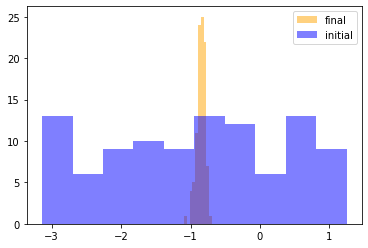

3
Base model gate value: 10
Gate edge angles: (-2.0570389598824015, -2.3839651267857658)
Gate value across ensemble: [-0.48827238 -0.49976491  0.48189987  0.42565645 -0.93924263  0.81282959
  0.48434032 -0.13725008 -1.46751756 -0.58831418 -0.81301687  0.89890882
 -1.01725992  0.80761199  0.02122778  0.45887404 -0.26189601 -1.31107668
 -0.95943186 -0.56855419 -0.08769913  1.15575802 -0.58473706 -0.31391309
 -0.30731032 -0.61802248 -0.85764511 -0.78013871 -1.47807182  0.0857722
 -1.90876077 -0.4545388  -0.93633601 -0.47375167  0.5524701  -0.22252048
 -2.06933098 -0.51518235 -0.6632164   0.33295629  0.1207494  -1.26372181
 -0.64675365 -1.13524844 -0.44289646 -1.98661386 -0.74126603 -0.50304451
 -1.35487902 -0.13625891 -0.77719096 -0.4778888   0.10638068 -1.96950004
 -0.41234189 -0.47441225 -0.5605578  -0.12254971  0.20421706 -0.54784121
 -0.54188064 -0.32305205 -0.67813559 -1.36458979 -0.27763007 -0.39434331
 -0.49167311  0.05050451 -1.28648267 -0.44252066 -0.54281011 -0.7240423
 -0.27792

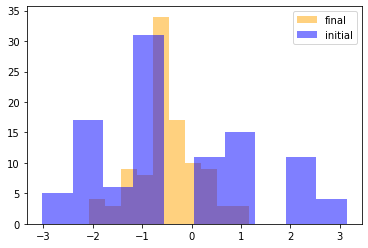

4
Base model gate value: 0
Gate edge angles: (3.0072712116368248, -2.646040980103965)
Gate value across ensemble: [-2.8441876  -1.63958498 -0.90476307 -1.56383415 -1.70362419 -1.72391041
 -1.88480531 -2.34521897 -1.60961556 -1.7819027  -1.64434658 -1.64847614
 -1.72301891 -1.81019712 -1.50668334 -0.93977594 -1.69638103 -1.71436218
 -1.09277635 -1.72850728 -1.71289425 -1.73529401 -1.59841414 -1.70430721
 -1.66793592 -1.31500454 -1.21235895 -1.7019857  -1.73897858 -1.50954131
 -1.69288845 -1.5295895  -1.70673223 -1.69920479 -1.67556679 -1.67616034
 -1.60505153 -1.60493242 -1.67445127 -1.62814364 -1.6952169  -0.77500579
 -1.78412122 -1.66110375 -2.43008215 -1.42267769 -1.74615537 -1.65286115
 -2.2228635  -1.60602769 -1.56498393 -1.69792797 -1.71035057 -1.58173269
 -1.71729192 -1.37792552 -1.68736896 -1.73700723 -2.2655386  -1.63381223
 -1.6419794  -1.64857913 -1.71168845 -1.71893259 -1.44803884 -1.76319354
 -2.36979592 -1.70696112 -1.73105324 -1.6847367  -1.72028747 -1.61660262
 -1.573747

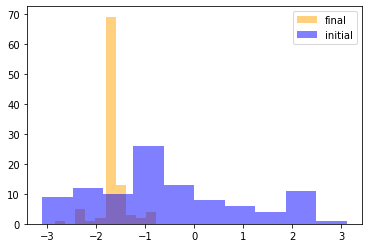

In [25]:
for i in range(enkf.population_size):
    print(i)
    present_gate_estimates(i)

* Look at standardisation
* scaling variables

In [ ]:
results.shape

#### Tidy up data

In [ ]:
results_cols = list(results)
error_types = [c for c in results_cols if c != 'time']

In [ ]:
base_error_types = ['forecast', 'obs', 'analysis', 'baseline']
ensemble_error_types = [e for e in error_types if e not in base_error_types]

In [ ]:
base_error_types

In [ ]:
ensemble_error_types

In [ ]:
base_tidy_df = tidy_dataframe(results, 'time', base_error_types)
base_tidy_df.head()

In [ ]:
ensemble_tidy_df = tidy_dataframe(results, 'time', ensemble_error_types)
ensemble_tidy_df.head()

In [ ]:
def analysis_to_model(row):
    model_number = row['variable'].split('_')[1]
    return f'Model {model_number}'

In [ ]:
ensemble_tidy_df['variable'] = ensemble_tidy_df.apply(analysis_to_model, axis=1)
ensemble_tidy_df.head()

### Ensemble member errors

In [ ]:
ensemble_mean = base_tidy_df.loc[base_tidy_df['variable']=='analysis', :]

In [ ]:
plt.figure(figsize=(8, 8))
sns.lineplot(x='time', y='value', hue='variable', alpha=0.3, data=ensemble_tidy_df)
plt.plot(ensemble_mean['time'], ensemble_mean['value'], linewidth=3,
         color='black', label='Ensemble mean')
plt.ylabel('Error per agent')
plt.xlabel('Time')
plt.legend()
plt.savefig(fig_dir + 'lineplot.pdf')
plt.show()

In [ ]:
benchmark_mean = base_tidy_df.loc[base_tidy_df['variable']=='baseline', :]

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(ensemble_mean['time'], ensemble_mean['value'], label='Filter ensemble mean')
plt.plot(benchmark_mean['time'], benchmark_mean['value'], label='Benchmark ensemble mean')
plt.xlabel('Time')
plt.ylabel('Error per agent')
plt.legend()
plt.savefig(fig_dir + 'benchmark.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
sns.kdeplot(x='time', y='value', data=ensemble_tidy_df, fill=True, label='Ensemble models')
plt.plot(ensemble_mean['time'], ensemble_mean['value'], label='Ensemble mean')
plt.ylabel('Error per agent')
plt.xlabel('Time')
plt.legend()
plt.savefig(fig_dir + 'contourplot.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
sns.lineplot(x='time', y='value', data=ensemble_tidy_df, label='Ensemble models')
plt.plot(ensemble_mean['time'], ensemble_mean['value'], label='Ensemble mean')
plt.ylabel('Error per agent')
plt.xlabel('Time')
plt.legend()
plt.savefig(fig_dir + 'lineplot_ci.pdf')
plt.show()

## Working - mean errors

Construct synthetic data:

In [ ]:
member_states = [{'x': 24, 'y': 26, 'label': 'Ensemble member'},
                  {'x': 23, 'y': 25, 'label': 'Ensemble member'},
                  {'x': 24, 'y': 24, 'label': 'Ensemble member'}]
mean_state = [{'x': 71/3, 'y': 25, 'label': 'Ensemble mean'}]
ground_state = [{'x': 25, 'y': 25, 'label': 'Ground truth'}]

working_states = member_states + mean_state + ground_state
                  
working_errors_df = pd.DataFrame(working_states)
working_errors_df

Construct line data:

In [ ]:
error_lines = [[[24, 25], [26, 25]],
               [[23, 25], [25, 25]],
               [[24, 25], [24, 25]],
               [[71/3, 25], [25, 25]]]

Plot:

In [ ]:
plt.figure()
sns.scatterplot(x='x', y='y', hue='label', data=working_errors_df, marker='x')
for el in error_lines:
    plt.plot(el[0], el[1], linestyle='dashed', color='grey', alpha=0.3)
plt.savefig(fig_dir + 'working_example.pdf')
plt.show()

Get means:

In [ ]:
members = working_errors_df.loc[working_errors_df['label']=='Ensemble member', :]
x_mean = members['x'].mean()
y_mean = members['y'].mean()

In [ ]:
en_mean = working_errors_df.loc[working_errors_df['label']=='Ensemble mean', :]

Check mean:

In [ ]:
assert x_mean == en_mean['x'].values[0]

In [ ]:
assert y_mean == en_mean['y'].values[0]

Error function:

In [ ]:
def calculate_error(ground_state, x, y):
    return np.sqrt((ground_state['x'] - x)**2 + (ground_state['y'] - y)**2)

Calculate mean error:

In [ ]:
ems = calculate_error(ground_state[0], mean_state[0]['x'], mean_state[0]['y'])
ems

Calculate member state errors:

In [ ]:
member_errors = list()
for m in member_states:
    member_errors.append(calculate_error(ground_state[0], m['x'], m['y']))

x = np.mean(member_errors)

In [ ]:
y = 2/3 * (np.sqrt(2) + 1)

Check that average error is correct:

In [ ]:
assert x == y

Check that error in mean state is less than or equal to the mean of the member model errors:

In [ ]:
assert ems <= x